In [1]:
# Defining Libraries:

import mne
import numpy as np
from scipy.signal import welch, stft
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.preprocessing import LabelEncoder
import torch
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
from itertools import cycle

In [2]:
# Defining File Paths:

file_participant_1 = 'Data/Participant_1.edf'
file_participant_2 = 'Data/Participant_2.edf'
file_participant_3 = 'Data/Participant_3.edf'
file_participant_4 = 'Data/Participant_4.edf'
file_participant_5 = 'Data/Participant_5.edf'
file_participant_6 = 'Data/Participant_6.edf'
file_participant_7 = 'Data/Participant_7.edf'
file_participant_8 = 'Data/Participant_8.edf'
file_participant_9 = 'Data/Participant_9.edf'
file_participant_10 = 'Data/Participant_10.edf'
file_participant_11 = 'Data/Participant_11.edf'
file_participant_12 = 'Data/Participant_12.edf'
file_participant_13 = 'Data/Participant_13.edf'

edf_data_files = [
    file_participant_1,
    file_participant_2,
    file_participant_3,
    file_participant_4,
    file_participant_5,
    file_participant_6,
    file_participant_7,
    file_participant_8,
    file_participant_9,
    file_participant_10,
    file_participant_11,
    file_participant_12,
    file_participant_13
]

In [3]:
# Remove Start, Finish and Breaks:

# Loading the first file to use as a reference for channel names:
reference_raw = mne.io.read_raw_edf(edf_data_files[0], preload = True)
reference_channels = reference_raw.info['ch_names']

raw_objects = []

# Define the segments of interest in seconds:
segments = [
    (30, 90),  # "I"
    (120, 180),  # "Yes"
    (210, 270),  # "No"
    (300, 360),  # "Want"
    (390, 450),  # "Help"
    (480, 540),  # "More"
    (570, 630),  # "That"
    (660, 720),  # "Stop"
    (750, 810),  # "Open"
    (840, 900)   # "Close"
]

for file_path in edf_data_files:
    print(f"Editing file: {file_path}...")
    raw = mne.io.read_raw_edf(file_path, preload = True)
    raw.pick_channels(reference_channels)
    
    # Create an empty list to store the segments:
    data_segments = []
    
    for start, end in segments:
        segment = raw.copy().crop(tmin = start, tmax = end)
        data_segments.append(segment)
    
    # Concatenate the segments:
    raw_concatenated = mne.concatenate_raws(data_segments)
    raw_objects.append(raw_concatenated)

Extracting EDF parameters from c:\Users\salib\OneDrive\Desktop\Masters Thesis Code\Data\Participant_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 117759  =      0.000 ...   919.992 secs...
Editing file: Data/Participant_1.edf...
Extracting EDF parameters from c:\Users\salib\OneDrive\Desktop\Masters Thesis Code\Data\Participant_1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 117759  =      0.000 ...   919.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Editing file: Data/Participant_2.edf...
Extracting EDF parameters from c:\Users\salib\OneDrive\Desktop\Masters Thesis Code\Data\Participant_2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 116479  =      0.000 ...   909.992 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Editing file:

In [4]:
# Displaying the Resulting Files after Segmentation:

raw_objects

[<RawEDF | Participant_1.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_2.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_3.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_4.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_5.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_6.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_7.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_8.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_9.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_10.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_11.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_12.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>,
 <RawEDF | Participant_13.edf, 60 x 76810 (600.1 s), ~35.2 MB, data loaded>]

In [5]:
# Concatenating all Loaded and Processed Files:

raw = mne.concatenate_raws(raw_objects)

In [6]:
# Function to Preprocess Raw Data:

def preprocess_raw_data(raw):

    print("STARTING PREPROCESSING: ")

    # Handling NaNs: Replace NaNs with the mean of the respective channel:
    raw_data = raw.get_data()

    for i in range(raw_data.shape[0]):
        nan_indices = np.isnan(raw_data[i])

        if np.any(nan_indices):
            mean_value = np.nanmean(raw_data[i])
            raw_data[i, nan_indices] = mean_value

    raw._data = raw_data

    print("\n")

    # Filtering: Bandpass filter between 4-30 Hz:
    raw.filter(4., 30., fir_design = 'firwin')

    print("\n")
    
    # Artifact Removal: Independent Component Analysis (ICA):
    ica = mne.preprocessing.ICA(n_components = 14, random_state = 97, max_iter = 800)
    ica.fit(raw)
    raw = ica.apply(raw)

    print("\n")
    
    # Spatial Filtering: Common Average Reference (CAR):
    raw.set_eeg_reference('average', projection = True)

    print("\n")
    
    # Channel Interpolation: Interpolate bad channels
    raw.interpolate_bads()

    print("\n")

    # Baseline Correction: Apply baseline correction using the mean of the segment
    raw.apply_function(lambda x: x - np.mean(x), picks = 'eeg')

    print("\n")
    print("PREPROCESSING DONE!")
    
    return raw

In [7]:
# Preprocessing the Raw Data:

raw = preprocess_raw_data(raw)

STARTING PREPROCESSING: 


Filtering raw data in 130 contiguous segments
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 845 samples (6.602 s)



Fitting ICA to data using 60 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Selecting by number: 14 components
Fitting ICA took 7.5s.
Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 0 ICA components
    Projecting back using 60 PCA components


EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.


Setting channel interpolation method to {'eeg': 'spline'}.




PREPROCESSING DONE!


C:\Users\salib\AppData\Local\Temp\ipykernel_14896\3882312654.py:39: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw.interpolate_bads()


In [8]:
# Creating Fixed-Length Epochs:

epoch_duration = 60  # seconds
start_times = np.arange(0, raw.times[-1] - epoch_duration, epoch_duration)
end_times = start_times + epoch_duration

In [9]:
# Displaying Epoch Start and End Times:

print("Start Times: ", start_times)
print("\nTotal Number of Start Times: ", len(start_times))
print("\n")
print("End Times: ", end_times)
print("\nTotal Number of End Times: ", len(end_times))

Start Times:  [   0.   60.  120.  180.  240.  300.  360.  420.  480.  540.  600.  660.
  720.  780.  840.  900.  960. 1020. 1080. 1140. 1200. 1260. 1320. 1380.
 1440. 1500. 1560. 1620. 1680. 1740. 1800. 1860. 1920. 1980. 2040. 2100.
 2160. 2220. 2280. 2340. 2400. 2460. 2520. 2580. 2640. 2700. 2760. 2820.
 2880. 2940. 3000. 3060. 3120. 3180. 3240. 3300. 3360. 3420. 3480. 3540.
 3600. 3660. 3720. 3780. 3840. 3900. 3960. 4020. 4080. 4140. 4200. 4260.
 4320. 4380. 4440. 4500. 4560. 4620. 4680. 4740. 4800. 4860. 4920. 4980.
 5040. 5100. 5160. 5220. 5280. 5340. 5400. 5460. 5520. 5580. 5640. 5700.
 5760. 5820. 5880. 5940. 6000. 6060. 6120. 6180. 6240. 6300. 6360. 6420.
 6480. 6540. 6600. 6660. 6720. 6780. 6840. 6900. 6960. 7020. 7080. 7140.
 7200. 7260. 7320. 7380. 7440. 7500. 7560. 7620. 7680. 7740.]

Total Number of Start Times:  130


End Times:  [  60.  120.  180.  240.  300.  360.  420.  480.  540.  600.  660.  720.
  780.  840.  900.  960. 1020. 1080. 1140. 1200. 1260. 1320. 1380. 1440.

In [10]:
# Defining the Words:

words = ['I', 'Yes', 'No', 'Want', 'Help', 'More', 'That', 'Stop', 'Open', 'Close']
print("Words: ", words)

Words:  ['I', 'Yes', 'No', 'Want', 'Help', 'More', 'That', 'Stop', 'Open', 'Close']


In [11]:
# Defining the Frequency:

sfreq = raw.info['sfreq']
print("Frequency Across Channels: ", sfreq, "Hz")

Frequency Across Channels:  128.0 Hz


In [12]:
# Feature Extraction Function:

def extract_features(epoch_data, sfreq):

    # Power Spectral Density (PSD) Features:
    freqs, psd = welch(epoch_data, sfreq, nperseg = int(sfreq)) # Compute PSD using Welch’s method.
    # Average power in the theta (4-8 Hz), alpha (8-12 Hz), and beta (12-30 Hz) frequency bands:
    theta_power = psd[:, (freqs > 4) & (freqs <= 8)].mean(axis = 1)
    alpha_power = psd[:, (freqs > 8) & (freqs <= 12)].mean(axis = 1)
    beta_power = psd[:, (freqs > 12) & (freqs <= 30)].mean(axis = 1)

    # Short-Time Fourier Transform (STFT) Features:
    _, _, Zxx = stft(epoch_data, fs = sfreq, nperseg = int(sfreq/2)) # Computes STFT.
    stft_power = np.abs(Zxx).mean(axis = 2) # Mean power from the STFT representation, averaged over time.
    
    # Combining Features into a single array with each feature as a column:
    features = np.stack([
        theta_power,
        alpha_power,
        beta_power,
        stft_power.mean(axis = 1)
    ], axis = 1) 

    return features

In [13]:
# Segmenting the Data into Epochs and Sub-Epochs:
# First -> 60 second epochs.
# Second -> 2 second sub-epochs.
# Third -> Extracting Features.

labeled_features_data = []
sub_epoch_duration = 2  # seconds

for i, (start, end) in enumerate(zip(start_times, end_times)): # Loops through each 30-second epoch:
    start_sample = int(start * sfreq)
    end_sample = int(end * sfreq)
    epoch_data, _ = raw[:, start_sample:end_sample] # Extracts the EEG data for the current epoch.
    word_label = words[i % len(words)] # Assigns a label to the current epoch using a list of predefined words.
    
    for j in range(int(epoch_duration / sub_epoch_duration)): # Iterate over Sub-Epochs:
        sub_start = j * sub_epoch_duration * int(sfreq)
        sub_end = (j + 1) * sub_epoch_duration * int(sfreq)
        sub_epoch_data = epoch_data[:, sub_start:sub_end]
        
        # Calls the extract_features function to extract from sub-epoch:
        features = extract_features(sub_epoch_data, sfreq)
        labeled_features_data.append((features, word_label)) # Stores the extracted features along with the label.

In [14]:
# Extracting Features and Labels:

features = np.array([f[0] for f in labeled_features_data])
labels = np.array([f[1] for f in labeled_features_data])

In [15]:
len(features)

3900

In [16]:
len(labels)

3900

In [17]:
labels

array(['I', 'I', 'I', ..., 'Close', 'Close', 'Close'], dtype='<U5')

In [18]:
# Preparing Data - Flattening & Scaling:

# Flattening the last two dimensions of the features array:
# To transform the 3D feature array into a 2D array where each row represents a single sample and each column represents a feature.
flattened_features = features.reshape(features.shape[0], -1)

# Scaling the features:
# To standardise the features by scaling them so that they have a mean of 0 and a standard deviation of 1.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(flattened_features)

In [19]:
# Code to check the Optimal Number of Features to be used for Training - ETA: 15 minutes:

#from sklearn.model_selection import cross_val_score
#from sklearn.svm import SVC
#from sklearn.pipeline import Pipeline

#num_features = scaled_features.shape[1] # Calculate the total number of features.
#k_values = range(5, num_features + 1, 5) # Define a range of possible values for k. 

#cv_scores = []

#for k in k_values:
    # Pipeline with SelectKBest and a classifier:
#    pipeline = Pipeline([
#        ('select', SelectKBest(mutual_info_classif, k = k)),
#        ('classify', SVC())  
#    ])

#    scores = cross_val_score(pipeline, scaled_features, labels, cv=5)  # 5-fold CV.
#    cv_scores.append(scores.mean())

# Determine the best k value:
#best_k = k_values[np.argmax(cv_scores)]
#print(f"Best number of features: {best_k}")

# Plotting the CV scores:
#plt.plot(k_values, cv_scores, marker = 'o')
#plt.xlabel('Number of Features')
#plt.ylabel('Cross-Validation Score')
#plt.title('Optimal Number of Features')
#plt.show()

# Use the best k value for mutual information feature selection
#mi_selector = SelectKBest(mutual_info_classif, k = best_k)
#features_mi = mi_selector.fit_transform(scaled_features, labels)

#selected_features = features_mi  # Choosing feature set to use for further model training

#num_features_mi = features_mi.shape[1]  # Number of features after MI

In [20]:
# Feature Selection Based on Mutual Information:

num_features = scaled_features.shape[1]
k_best = min(num_features, 75)  
mi_selector = SelectKBest(mutual_info_classif, k = k_best)
features_mi = mi_selector.fit_transform(scaled_features, labels)
selected_features = features_mi 
num_features_mi = features_mi.shape[1]  

In [21]:
num_features_mi

75

In [22]:
num_features

240

In [23]:
k_best

75

In [24]:
# Creating Train, Test and Validation Sets (80, 10, 10):

train_features, test_features, train_labels, test_labels = train_test_split(
    selected_features, labels, test_size = 0.2, random_state = 42, stratify = labels)

val_features, test_features, val_labels, test_labels = train_test_split(
    test_features, test_labels, test_size = 0.5, random_state = 42, stratify = test_labels)

In [25]:
# Displaying Dataset Distribution:

print(f"Training: {len(train_features)}")
print(f"Validation: {len(val_features)}")
print(f"Testing: {len(test_features)}")

Training: 3120
Validation: 390
Testing: 390


In [26]:
# Designing Training Dataset:

class EEGDataset(Dataset):

    def __init__(self, features, labels):

        self.features = torch.tensor(features, dtype = torch.float32)
        self.labels = torch.tensor(labels, dtype = torch.long)
    
    def __len__(self):

        features_len = len(self.features)
        return features_len
    
    def __getitem__(self, idx):

        feat = self.features[idx]
        labels = self.labels[idx]
        return feat, labels 

In [27]:
# String -> Integers for Training:

label_encoder = LabelEncoder()
train_dataset = EEGDataset(train_features, label_encoder.fit_transform(train_labels))
val_dataset = EEGDataset(val_features, label_encoder.transform(val_labels))
test_dataset = EEGDataset(test_features, label_encoder.transform(test_labels))

# Print each label and its equivalent encoded label:
for label, encoded_label in zip(label_encoder.classes_, range(len(label_encoder.classes_))):
    print(f'Label: {label}, Encoded: {encoded_label}')

train_loader = DataLoader(train_dataset, batch_size = 256, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 256)
test_loader = DataLoader(test_dataset, batch_size = 256)

Label: Close, Encoded: 0
Label: Help, Encoded: 1
Label: I, Encoded: 2
Label: More, Encoded: 3
Label: No, Encoded: 4
Label: Open, Encoded: 5
Label: Stop, Encoded: 6
Label: That, Encoded: 7
Label: Want, Encoded: 8
Label: Yes, Encoded: 9


In [28]:
# CNN Architecture:

class CNNModel(nn.Module):
    def __init__(self, num_features, num_classes):

        super(CNNModel, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size = 2, stride = 2)
        
        self.conv2 = nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm1d(32)
        
        # Initialise the fully connected layer:
        self.fc1 = nn.Linear(32 * (num_features // 4), 128)
        self.fc2 = nn.Linear(128, num_classes)
        
    def forward(self, x):

        x = x.unsqueeze(1) 
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        
        x = x.view(x.size(0), -1)  # Flatten the tensor.
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [29]:
# Define Training and Evaluation Functions:

def train(model, train_loader, criterion, optimizer, device):

    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    
    return epoch_loss, all_labels, all_preds

def evaluate(model, val_loader, criterion, device):

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():

        for inputs, labels in val_loader:

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc, all_labels, all_preds

In [30]:
# Preparing for Training:

# Set device to GPU if available:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_features = train_features.shape[1]
num_classes = len(np.unique(label_encoder.fit_transform(train_labels)))

model = CNNModel(num_features, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

# Model Architecture:
summary(model, input_size = (1, num_features))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 10]                   --
├─Conv1d: 1-1                            [1, 16, 75]               64
├─BatchNorm1d: 1-2                       [1, 16, 75]               32
├─ReLU: 1-3                              [1, 16, 75]               --
├─MaxPool1d: 1-4                         [1, 16, 37]               --
├─Conv1d: 1-5                            [1, 32, 37]               1,568
├─BatchNorm1d: 1-6                       [1, 32, 37]               64
├─ReLU: 1-7                              [1, 32, 37]               --
├─MaxPool1d: 1-8                         [1, 32, 18]               --
├─Linear: 1-9                            [1, 128]                  73,856
├─ReLU: 1-10                             [1, 128]                  --
├─Linear: 1-11                           [1, 10]                   1,290
Total params: 76,874
Trainable params: 76,874
Non-trainable params: 0
Total

In [31]:
# Training Loop with Early Stopping:

num_epochs = 1500
best_val_acc = 0.0
patience = 20
counter = 0

train_losses = []
val_losses = []
val_accuracies = []
train_metrics = []

for epoch in range(num_epochs):

    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss, train_labels, train_preds = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_labels, val_preds = evaluate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict()
        torch.save(best_model_wts, 'Phase_1/Final_Models/CNN_Model.pth')  # Save the best model weights
        counter = 0  # Reset counter if validation accuracy improves
    else:
        counter += 1
    
    print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    if counter >= patience:
        print("Early stopping")
        break

model.load_state_dict(torch.load('Phase_1/Final_Models/CNN_Model.pth')) # Load best model weights

# Test the model during training:
test_loss, test_acc, test_labels, test_preds = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Epoch 1/1500
Train Loss: 2.2604, Val Loss: 2.2607, Val Acc: 0.1487
Epoch 2/1500
Train Loss: 2.1068, Val Loss: 2.1683, Val Acc: 0.2410
Epoch 3/1500
Train Loss: 1.9307, Val Loss: 2.0291, Val Acc: 0.3179
Epoch 4/1500
Train Loss: 1.7459, Val Loss: 1.8173, Val Acc: 0.4000
Epoch 5/1500
Train Loss: 1.5532, Val Loss: 1.6045, Val Acc: 0.4564
Epoch 6/1500
Train Loss: 1.3909, Val Loss: 1.4671, Val Acc: 0.5231
Epoch 7/1500
Train Loss: 1.2342, Val Loss: 1.3380, Val Acc: 0.5744
Epoch 8/1500
Train Loss: 1.0864, Val Loss: 1.1838, Val Acc: 0.6487
Epoch 9/1500
Train Loss: 0.9594, Val Loss: 1.1250, Val Acc: 0.6590
Epoch 10/1500
Train Loss: 0.8556, Val Loss: 0.9886, Val Acc: 0.7282
Epoch 11/1500
Train Loss: 0.7629, Val Loss: 0.9183, Val Acc: 0.7538
Epoch 12/1500
Train Loss: 0.6864, Val Loss: 0.8481, Val Acc: 0.7769
Epoch 13/1500
Train Loss: 0.6140, Val Loss: 0.8020, Val Acc: 0.7744
Epoch 14/1500
Train Loss: 0.5622, Val Loss: 0.7366, Val Acc: 0.8103
Epoch 15/1500
Train Loss: 0.4979, Val Loss: 0.6883, Val A

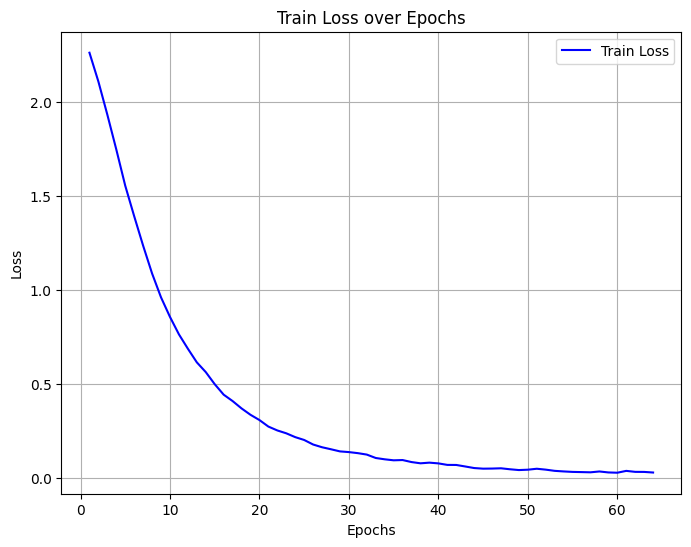

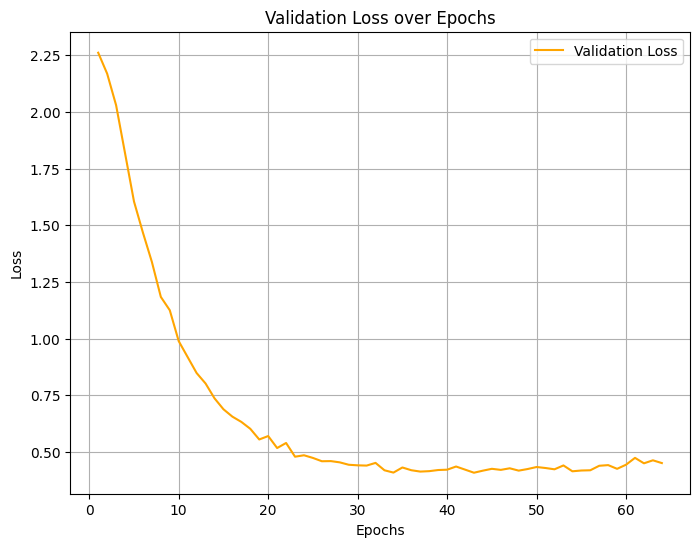

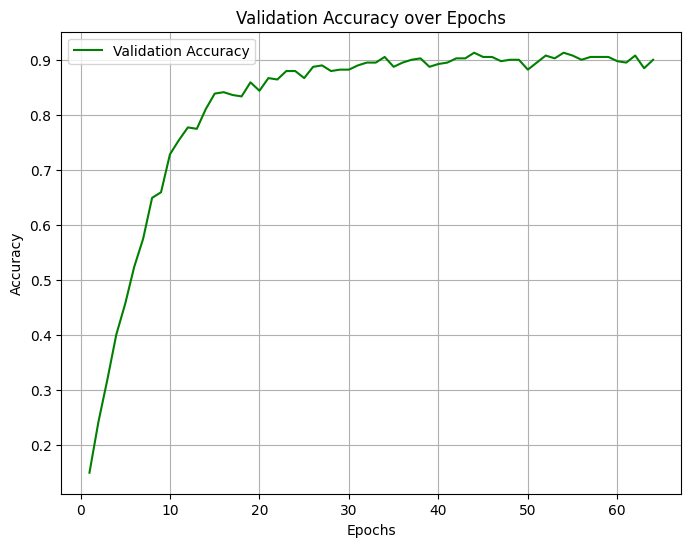

In [32]:
# Accuracy and Loss over Epochs:

epochs = range(1, len(train_losses) + 1)

# Train Loss:
plt.figure(figsize = (8, 6))
plt.plot(epochs, train_losses, label = 'Train Loss', color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Validation Loss:
plt.figure(figsize = (8, 6))
plt.plot(epochs, val_losses, label = 'Validation Loss', color = 'orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Validation Accuracy:
plt.figure(figsize = (8, 6))
plt.plot(epochs, val_accuracies, label = 'Validation Accuracy', color = 'green')
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Evaluation Function:

def calculate_metrics(labels, preds, dataset_name):

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average = 'weighted')
    recall = recall_score(labels, preds, average = 'weighted')
    f1 = f1_score(labels, preds, average = 'weighted')
    class_report = classification_report(labels, preds)
    conf_matrix = confusion_matrix(labels, preds)
    std_dev = np.std(preds)
    kappa = cohen_kappa_score(labels, preds)
    mcc = matthews_corrcoef(labels, preds)

    # Binarize the labels for ROC curve calculation
    n_classes = 10
    labels_binarized = label_binarize(labels, classes = range(n_classes))
    preds_binarized = label_binarize(preds, classes = range(n_classes))

    # Compute ROC curve and ROC area for each class:
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], preds_binarized[:, i])
        roc_auc[i] = roc_auc_score(labels_binarized[:, i], preds_binarized[:, i])

     # Compute Precision-Recall curve and PR area for each class:
    precision_curve = dict()
    recall_curve = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision_curve[i], recall_curve[i], _ = precision_recall_curve(labels_binarized[:, i], preds_binarized[:, i])
        average_precision[i] = average_precision_score(labels_binarized[:, i], preds_binarized[:, i])

    print(f'---------- {dataset_name} Evaluation Metrics: ----------\n')
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')
    print("\n")

    print(f'Cohen\'s Kappa: {kappa:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print("\n")

    print('Classification Report:')
    print(class_report)
    print("\n")

    print('Confusion Matrix:')
    print("\n")
    plt.figure(figsize = (10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'Blues', xticklabels = words, yticklabels = words)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.show()

    print(f'Standard Deviation: {std_dev:.4f}\n')

    print("ROC Curve and AUC Scores: ")
    # Plot ROC curve
    plt.figure(figsize = (10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color = color, lw = 2,
                 label = f'ROC curve of class {words[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw = 2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{dataset_name} ROC Curve')
    plt.legend(loc = "lower right")
    plt.show()

    print("Precision-Recall Curve: ")
    # Plot Precision-Recall curve
    plt.figure(figsize=(10, 7))
    for i, color in zip(range(n_classes), colors):
        plt.plot(recall_curve[i], precision_curve[i], color = color, lw = 2,
                 label=f'PR curve of class {words[i]} (area = {average_precision[i]:0.2f})')

    plt.plot([0, 1], [1, 0], 'k--', lw = 2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{dataset_name} Precision-Recall Curve')
    plt.legend(loc = "lower left")
    plt.show()

---------- Training Evaluation Metrics: ----------

Accuracy: 0.9968
Precision: 0.9968
Recall: 0.9968
F1-score: 0.9968


Cohen's Kappa: 0.9964
Matthews Correlation Coefficient: 0.9964


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       312
           1       1.00      1.00      1.00       312
           2       1.00      0.99      1.00       312
           3       1.00      1.00      1.00       312
           4       1.00      1.00      1.00       312
           5       1.00      0.98      0.99       312
           6       1.00      1.00      1.00       312
           7       1.00      1.00      1.00       312
           8       1.00      1.00      1.00       312
           9       0.99      1.00      1.00       312

    accuracy                           1.00      3120
   macro avg       1.00      1.00      1.00      3120
weighted avg       1.00      1.00      1.00      3120



Confusion Matrix:




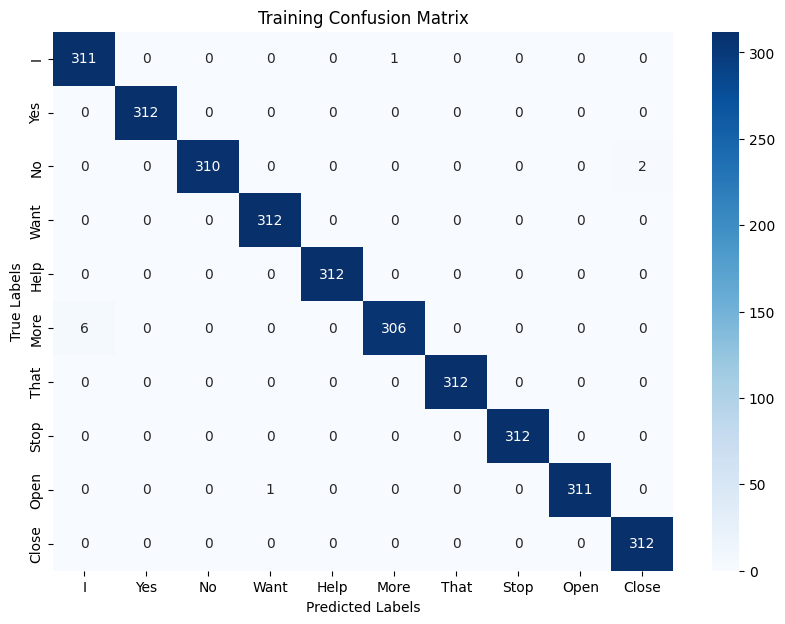

Standard Deviation: 2.8789

ROC Curve and AUC Scores: 


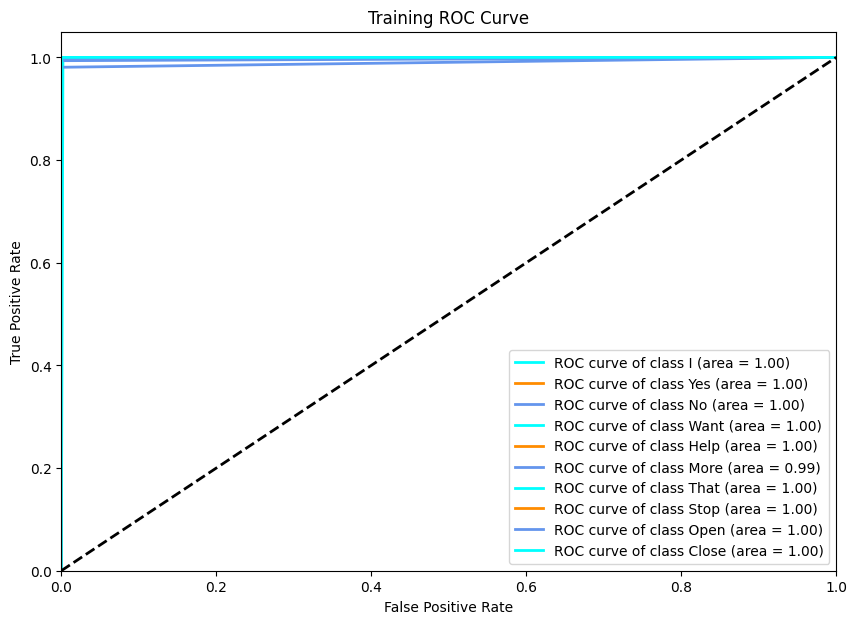

Precision-Recall Curve: 


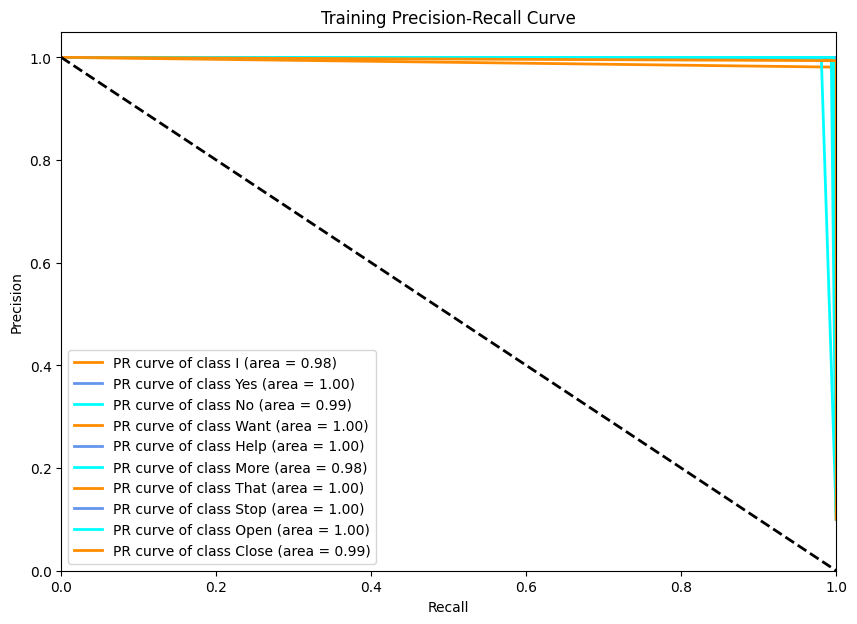

---------- Testing Evaluation Metrics: ----------

Accuracy: 0.9487
Precision: 0.9510
Recall: 0.9487
F1-score: 0.9484


Cohen's Kappa: 0.9430
Matthews Correlation Coefficient: 0.9433


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.95      0.93        39
           1       0.97      0.95      0.96        39
           2       1.00      0.92      0.96        39
           3       0.93      0.97      0.95        39
           4       1.00      1.00      1.00        39
           5       1.00      0.82      0.90        39
           6       0.90      0.95      0.93        39
           7       0.92      0.92      0.92        39
           8       0.91      1.00      0.95        39
           9       0.97      1.00      0.99        39

    accuracy                           0.95       390
   macro avg       0.95      0.95      0.95       390
weighted avg       0.95      0.95      0.95       390



Confusion Matrix:




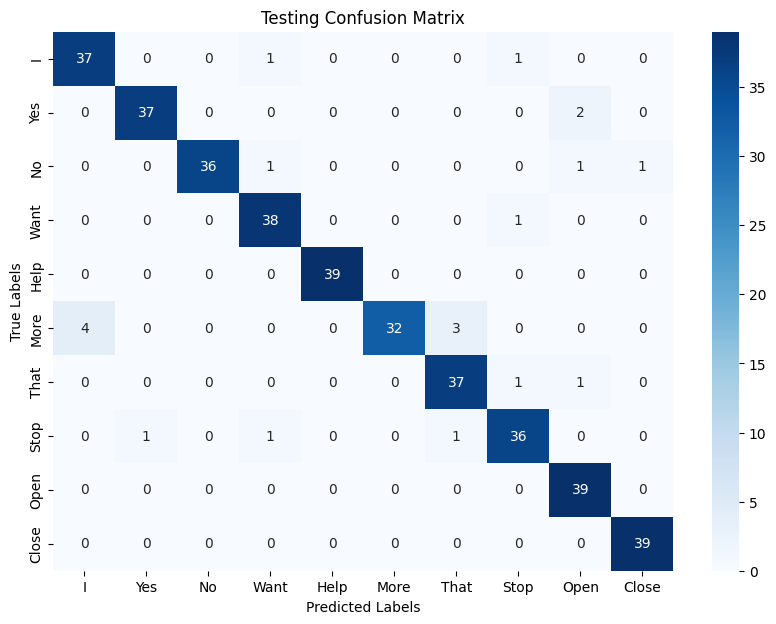

Standard Deviation: 2.9101

ROC Curve and AUC Scores: 


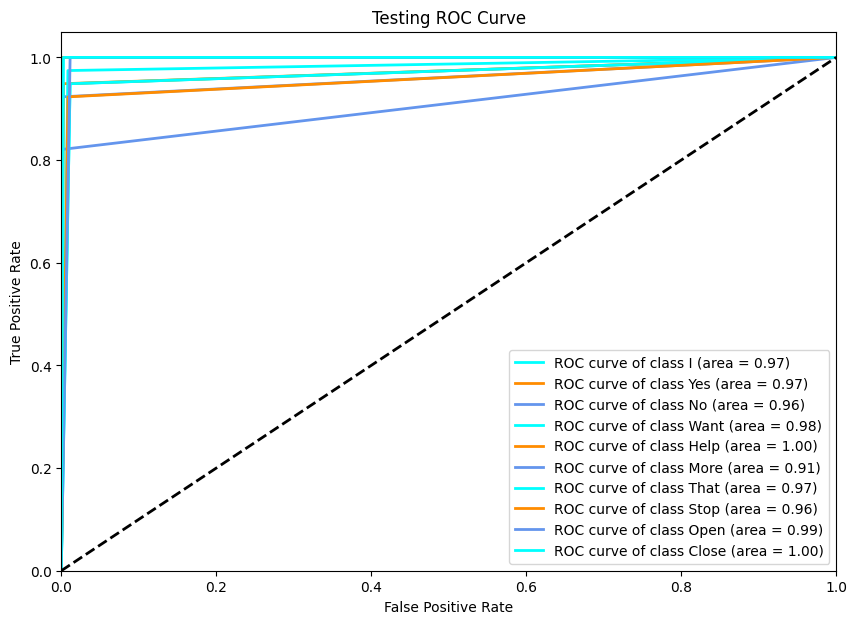

Precision-Recall Curve: 


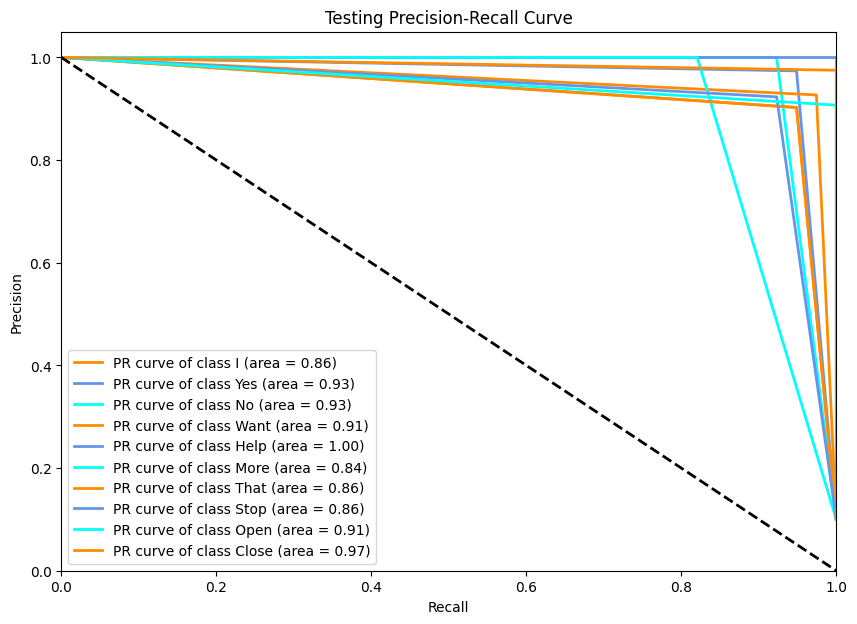

In [34]:
# Calculate metrics for the Training and Test Sets:

train_metrics = calculate_metrics(train_labels, train_preds, "Training")
test_metrics = calculate_metrics(test_labels, test_preds, "Testing")


In [35]:
# Real-time Predictions:

def predict(model, input_data, device):
    model.eval()
    input_data = torch.tensor(input_data, dtype=torch.float32).to(device)
    with torch.no_grad():
        output = model(input_data)
        _, predicted = torch.max(output.data, 1)
    return predicted.cpu().numpy()

# Load the trained model weights
model.load_state_dict(torch.load('Phase_1/Final_Models/CNN_Model.pth'))

# Example usage
sample_inputs = test_features[:10]  # Take five samples from the test set
actual_labels = test_labels[:10]

predicted_labels = predict(model, sample_inputs, device)

# Print actual vs predicted labels
for actual, predicted in zip(actual_labels, predicted_labels):
    print(f'Actual: {label_encoder.inverse_transform([actual])[0]}, Predicted: {label_encoder.inverse_transform([predicted])[0]}')

Actual: Stop, Predicted: Stop
Actual: That, Predicted: That
Actual: Open, Predicted: Open
Actual: Yes, Predicted: Yes
Actual: That, Predicted: That
Actual: Stop, Predicted: Stop
Actual: Open, Predicted: Open
Actual: Close, Predicted: Close
Actual: More, Predicted: More
Actual: That, Predicted: That
